In [1]:
# Adaptive Robust Lot-Sizing
from rsome import ro
import rsome.grb_solver as grb
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt

# Parameters of the lot-sizing problem
N = 30
c = 20
dmax = 20
Gamma = 20*np.sqrt(N)
xy = 10*rd.rand(2, N)
t = ((xy[[0]] - xy[[0]].T) ** 2
     + (xy[[1]] - xy[[1]].T) ** 2) ** 0.5

model = ro.Model()          # define a model
x = model.dvar(N)           # define location decisions
y = model.ldr((N, N))       # define decision rule as the shifted quantities
d = model.rvar(N)           # define random variables as the demand

y.adapt(d)                  # the decision rule y affinely depends on d

uset = (d >= 0,
        d <= dmax,
        sum(d) <= Gamma)    # define the uncertainty set

# define model objective and constraints
model.minmax((c*x).sum() + (t*y).sum(), uset)
model.st(d <= y.sum(axis=0) - y.sum(axis=1) + x)
model.st(y >= 0)
model.st(x >= 0)
model.st(x <= 20)

model.solve(grb)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Being solved by Gurobi...
Solution status: 2
Running time: 1.3594s


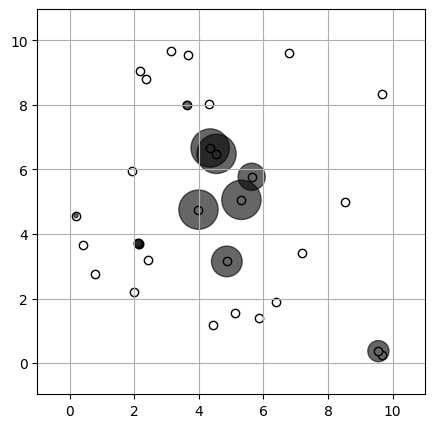

In [2]:
plt.figure(figsize=(5, 5))
plt.scatter(xy[0], xy[1], c='w', edgecolors='k')
plt.scatter(xy[0], xy[1], s=40*x.get(), c='k', alpha=0.6)
plt.axis('equal')
plt.xlim([-1, 11])
plt.ylim([-1, 11])
plt.grid()
plt.show()

# Adaptive Robust Lot-Sizing 问题

在这个例子中，我们考虑了Bertsimas和de Ruiter（2016）中描述的批量规划问题。

在一个具有 $N$ 个商店的网络中，对于每个商店 $i$，存货分配 $x_i$ 是在**了解每个位置的需求实现之前确定的**。需求，由向量$d$表示，是不确定的，假设在一个预算不确定性集合中。

$$\mathcal{U} = \{ \boldsymbol{d} : \boldsymbol{0} \leq \boldsymbol{d} \leq d_{\max}\boldsymbol{e}, \boldsymbol{e}^{\top}\boldsymbol{d} \leq \Gamma \}$$

在观察到需求实现后，可以以成本 $t_{ij}$ 的方式从商店 $i$ 运输存货 $y_{ij}$ 到商店 $j$， 以满足所有需求。**目标是最小化最坏情况下的总成本**，表示为存储成本（每个商店 $i$ 的单位成本 $c_i$）和产品从一家商店转移到另一家商店的成本。这样的自适应模型可以写成:

$$\begin{aligned}
\min_{d \in \mathcal{U}} \quad & \max \sum_{i=1}^{N} c_i x_i + \sum_{i=1}^{N}\sum_{j=1}^{N} t_{ij} y_{ij} \\[8pt]
\text{s.t.} \quad & d_i \leq \sum_{j=1}^{N} y_{ji} - \sum_{j=1}^{N} y_{ij} + x_i, && i = 1,2,\dots,N,\quad \forall \boldsymbol{d} \in \mathcal{U} \\[8pt]
& 0 \leq x_i \leq K_i, && i = 1,2,\dots,N
\end{aligned}$$


其中 $K_i$ 是每个位置的存货容量，自适应决策 $y_{ij}$ 可以近似为

$$y_{ij}(\boldsymbol{d}) = y_{ij}^{0} + \sum_{k=1}^{N} y_{ijk}^{d}\, d_{k},$$

换句话说，每个等待观察的决策$y_{ij}$的线性决策规则为$L([N])$。对于一个测试案例，我们从$[0,10]^2$中均匀随机选择$N=30$个位置。移位成本$t_{ij}$计算为商店i和j之间的欧氏距离，存储成本 $c_i$ 假定为20。最大需求dmax和存货容量 $K_i$ 都设置为20个单位，不确定性集合中的参数$Γ$设置为$20\sqrt{N}$的平方根。这样的自适应模型可以通过以下Python代码使用RSOME来实现。